Đánh giá và so sánh hiệu suất của các tổ hợp khác nhau
test 1

# IMPORT LIBRARIES & DATA

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.GA import solve
from src.TSP import compute_distance_matrix, visualize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
RESULTS_FILE = "cached_results.pkl"

In [3]:

file_path = '../data/5_CentralRegion.csv'

In [4]:
locations = pd.read_csv(file_path, header=None).values
locations 

array([['province', 'lat', 'lon'],
       ['Thanh Hóa', '19.9781573', '105.4816107'],
       ['Nghệ An', '19.1976001', '105.0606760'],
       ['Hà Tĩnh', '18.3504832', '105.7623047'],
       ['Quảng Bình', '17.5095990', '106.4004452'],
       ['Quảng Trị', '16.7897806', '106.9797431'],
       ['Thừa Thiên Huế', '16.4639321', '107.5863388'],
       ['Quảng Nam', '15.5761698', '108.0527132'],
       ['Quảng Ngãi', '14.9953739', '108.6917290'],
       ['Bình Định', '14.0779378', '108.9898798'],
       ['Phú Yên', '13.1912633', '109.1273678'],
       ['Khánh Hòa', '12.2980751', '108.9950386'],
       ['Ninh Thuận', '11.6965639', '108.8928476'],
       ['Bình Thuận', '11.1041572', '108.1832931'],
       ['Kon Tum', '14.6995372', '107.9323831'],
       ['Gia Lai', '13.8177445', '108.2004015'],
       ['Đắk Lắk', '12.8292274', '108.2999058'],
       ['Đắk Nông', '12.2818851', '107.7302484'],
       ['Lâm Đồng', '11.6614957', '108.1335279'],
       ['Đà Nẵng', '16.0680000', '108.2120000']], dt

In [5]:
locations_numeric = locations[1:, 1:].astype(float)

distance_matrix = compute_distance_matrix(locations_numeric)

In [6]:
# Danh sách các thuật toán
mutation_algorithms = ['swap', 'scramble', 'inversion', 'insertion']
crossover_algorithms = ['order', 'single_point', 'two_point', 'uniform']
selection_algorithms = ['elitism', 'tournament', 'rank', 'roulette_wheel']

3 tham số mặc định là: 
- population_size = 100
- generations = 200
- mutation_rate = 0.01

# COMBINATION COMPARISON

In [7]:

def compute_and_cache_results(distance_matrix):
    results = []

    for mutation in mutation_algorithms:
        for crossover in crossover_algorithms:
            for selection in selection_algorithms:
                best_distance, best_route, fitness_history = solve(
                    distance_matrix,
                    population_size=100,
                    generations=200,
                    mutation_rate=0.01,
                    mutation_algorithm=mutation,
                    crossover_algorithm=crossover,
                    selection_algorithm=selection
                )

                fir = (fitness_history[0] - fitness_history[-1]) / len(fitness_history)
                x = np.arange(len(fitness_history))
                area = auc(x, fitness_history)

                results.append({
                    'mutation': mutation,
                    'crossover': crossover,
                    'selection': selection,
                    'fitness_history': fitness_history,
                    'fir': fir,
                    'auc': area
                })

    # Save results to file
    with open(RESULTS_FILE, "wb") as f:
        pickle.dump(results, f)

    return results

def load_cached_results():
    if os.path.exists(RESULTS_FILE):
        with open(RESULTS_FILE, "rb") as f:
            return pickle.load(f)
    else:
        return None

def get_result_by_combination(mutation, crossover, selection, results):
    for r in results:
        if r['mutation'] == mutation and r['crossover'] == crossover and r['selection'] == selection:
            return r
    return None

In [8]:
def plot_single_combination_result(mutation, crossover, selection, results):
    r = get_result_by_combination(mutation, crossover, selection, results)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(r['fitness_history'])

    # Tiêu đề
    ax.set_title(
        f"mut: {r['mutation']}, cross: {r['crossover']}, sel: {r['selection']}",
        fontsize=10
    )

    # Nhãn trục
    ax.set_xlabel("Generation")
    ax.set_ylabel("Fitness")
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # AUC
    ax.text(0.95, 0.78, f"AUC: {r['auc']:.1f}", transform=ax.transAxes,
            ha='right', va='bottom', fontsize=11, color='blue',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

    # FIR
    color = 'green' if r['fir'] >= 0.05 else 'red'
    ax.text(0.95, 0.68, f"FIR: {r['fir']:.3f}", transform=ax.transAxes,
            ha='right', va='bottom', fontsize=11, color=color,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_fitness_grid(distance_matrix):
    results = load_cached_results()
    if results is None:
        results = compute_and_cache_results(distance_matrix)

    results.sort(key=lambda x: x['auc'])

    fig, axes = plt.subplots(11, 6, figsize=(18, 33))
    fig.subplots_adjust(hspace=0.7)

    for index, result in enumerate(results):
        row = index // 6
        col = index % 6
        ax = axes[row][col]

        ax.plot(result['fitness_history'])
        ax.set_title(
            f"mut: {result['mutation']}, cross: {result['crossover']}, sel: {result['selection']}",
            fontsize=8
        )
        ax.tick_params(axis='x', labelsize=11)
        ax.tick_params(axis='y', labelsize=11)

        ax.text(0.95, 0.78, f"AUC: {result['auc']:.1f}", transform=ax.transAxes,
                ha='right', va='bottom', fontsize=11, color='blue',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

        color = 'green' if result['fir'] >= 0.05 else 'red'
        ax.text(0.95, 0.68, f"FIR: {result['fir']:.3f}", transform=ax.transAxes,
                ha='right', va='bottom', fontsize=11, color=color,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

    for i in range(len(results), 66):
        row = i // 6
        col = i % 6
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.savefig("fitness_grid.png", dpi=300)
    plt.show()

In [10]:
results = compute_and_cache_results(distance_matrix)

In [11]:
# Load kết quả đã tính
results = load_cached_results()

# Truy xuất dữ liệu theo tổ hợp thuật toán
r = get_result_by_combination('swap', 'single_point', 'tournament', results)

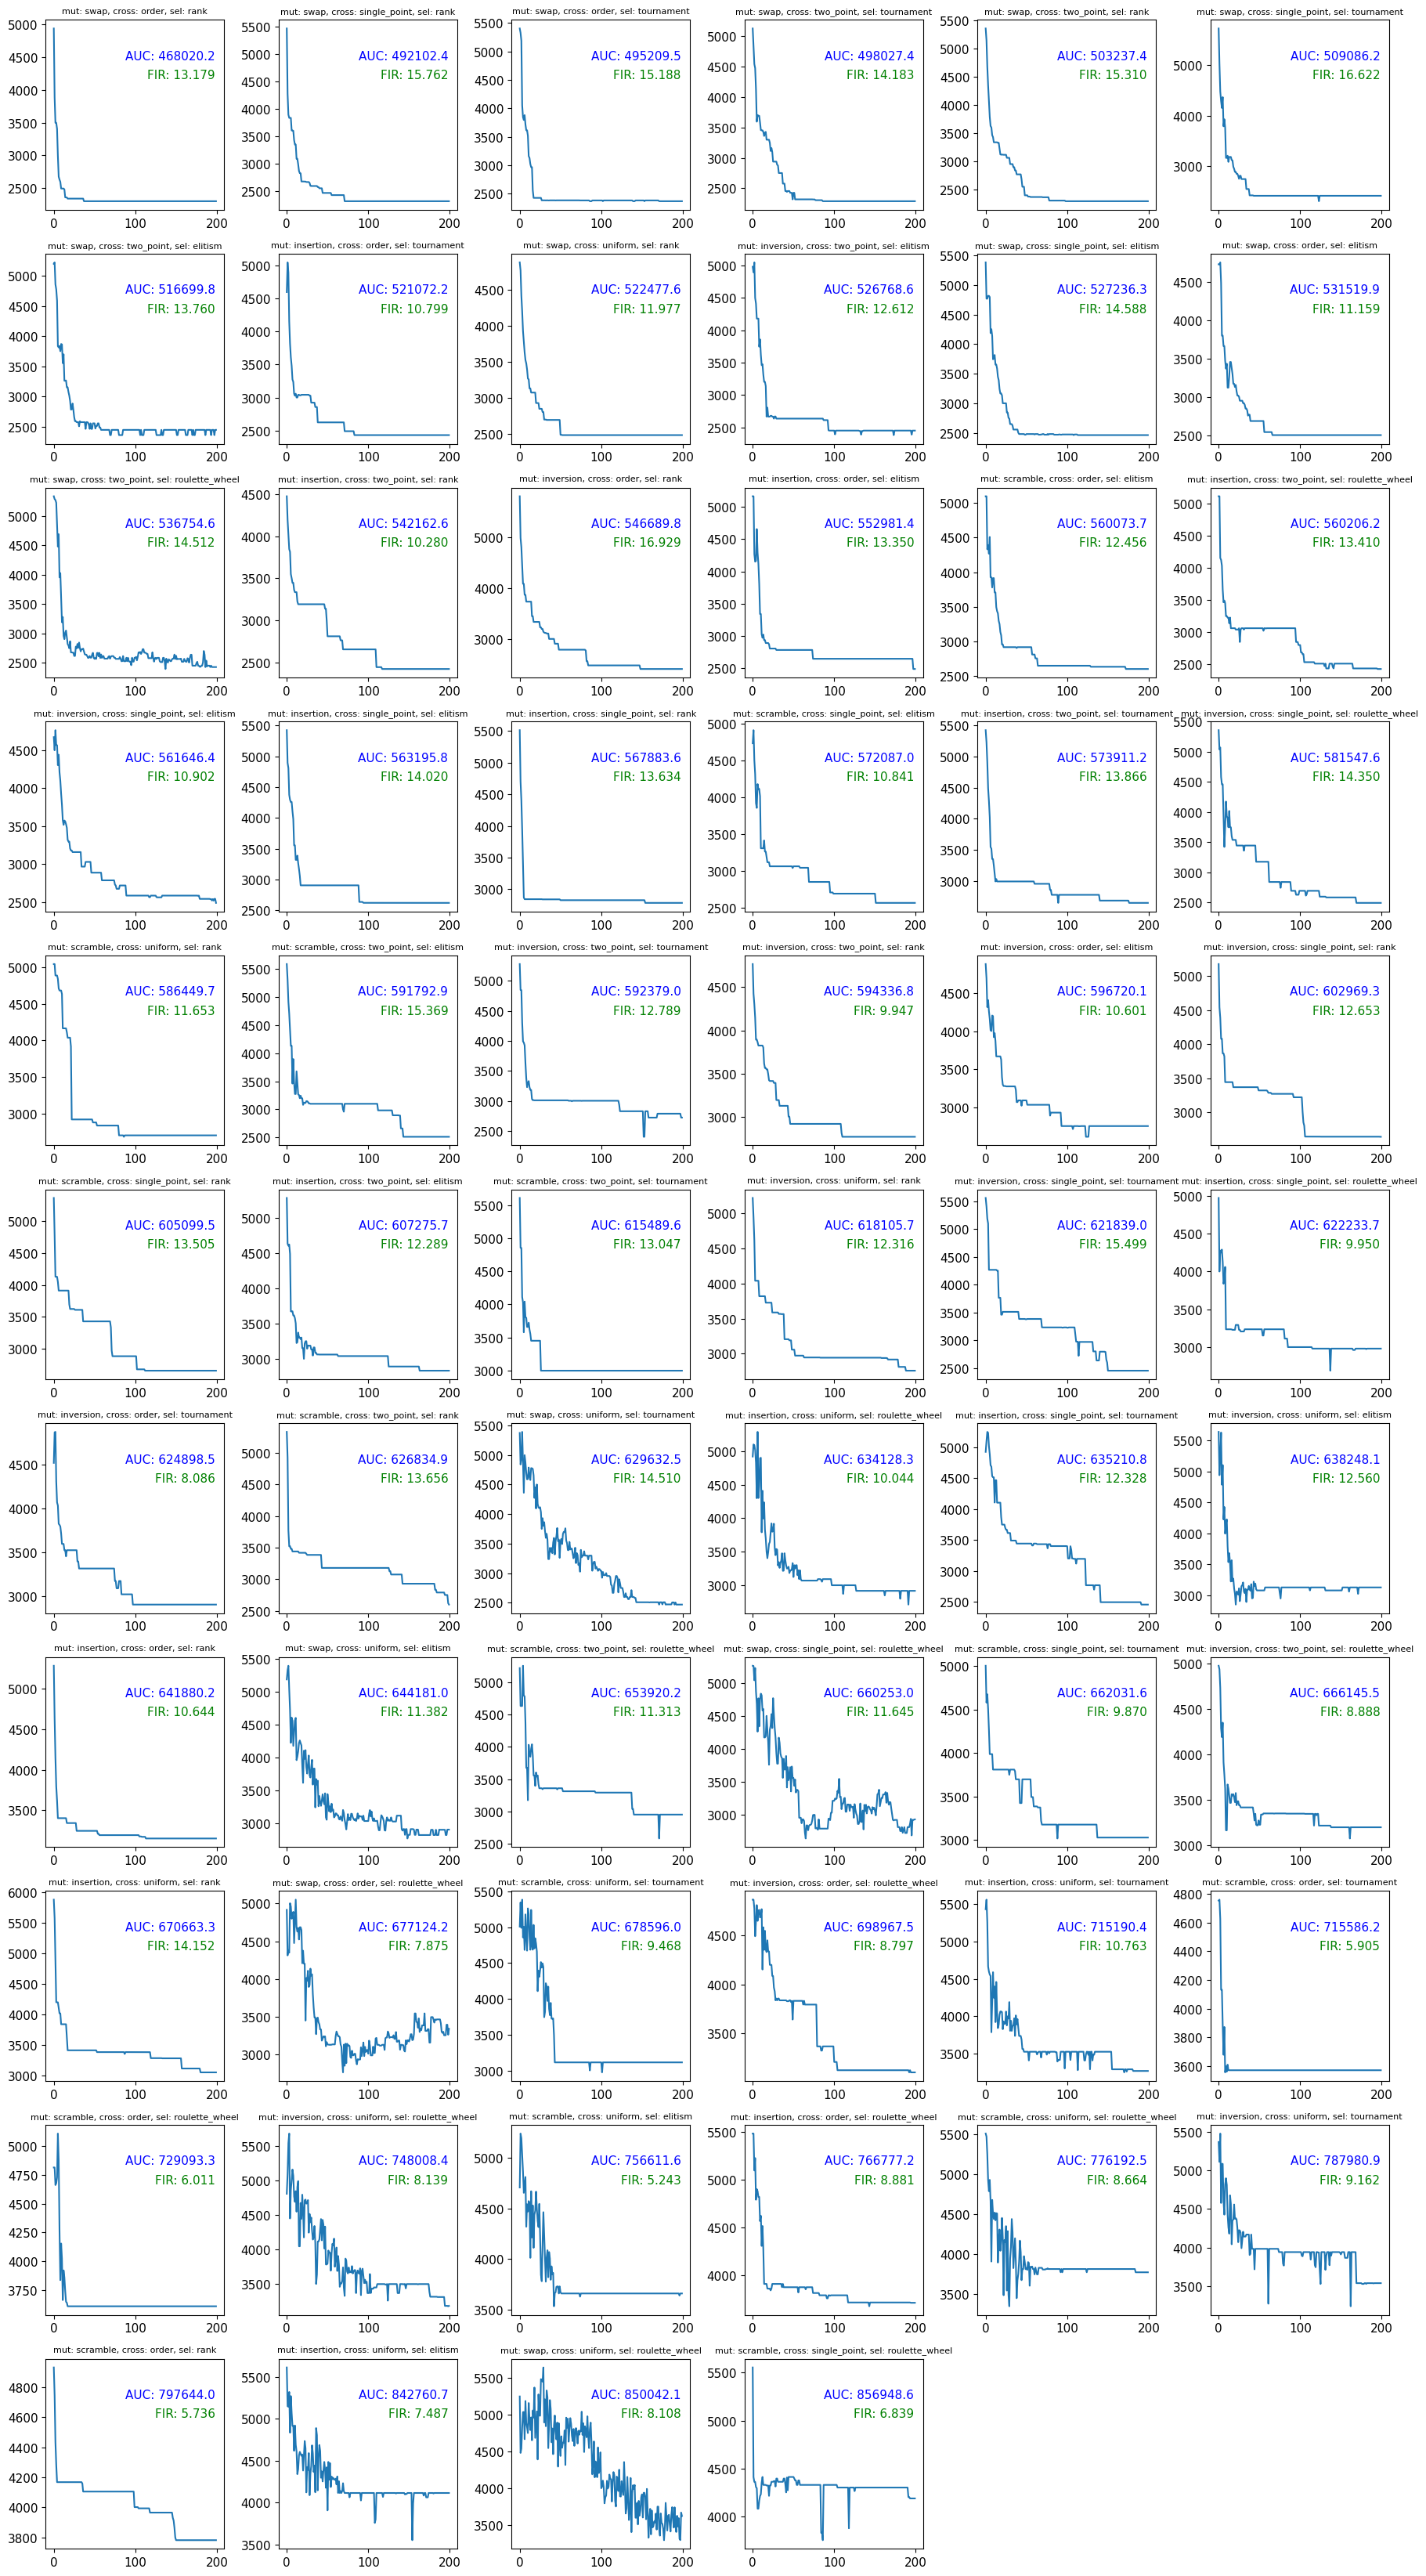

In [12]:
plot_fitness_grid(distance_matrix)

## Tổng quan

- FIR (Fitness Improvement Rate): phản ánh **tốc độ cải thiện độ phù hợp** của mô hình theo thời gian.  
- AUC (Area Under Curve) đại diện cho **chất lượng hội tụ tổng thể** trong suốt quá trình huấn luyện.
- FIR cao + AUC thấp → Hội tụ nhanh và hiệu quả.
- FIR thấp + AUC cao → Hội tụ chậm hoặc kém hiệu quả.

---

## Nhận xét về các tổ hợp mô hình

- Các mô hình **hiệu quả** thường sử dụng:
  - Mutation: `swap`
  - Selection: `rank`
  - Crossover: `two_point`

- Các mô hình **kém hiệu quả** thường sử dụng:
  - Crossover: `uniform`
  - Selection: `roulette_wheel`


In [13]:


# Vẽ lại biểu đồ
def plot_fitness(fitness):
    plt.plot(fitness)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Over Generations")
    plt.show()

# TRƯỜNG HỢP 1: Mặc định
- mutation: swap 
- crossover: single_point
- selection: tournament


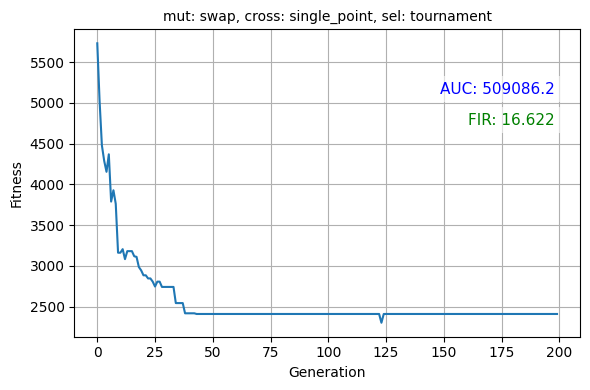

In [24]:
plot_single_combination_result('swap', 'single_point', 'tournament', results)
    

**Nhận xét (mut: swap, cross: single_point, sel: tournament):**

- **Giai đoạn đầu (0–20 thế hệ):** Fitness giảm nhanh chóng từ khoảng **5600** xuống **2400**, cho thấy quá trình tiến hóa ban đầu hoạt động hiệu quả trong việc tìm kiếm nghiệm tốt hơn.
- **Giai đoạn sau:** Fitness dừng lại và duy trì ở mức ổn định quanh **2400**, không cải thiện đáng kể sau thế hệ **40** → có thể thuật toán đã **hội tụ sớm**.
- **AUC:** **509086.2**, **FIR:** **16.622** → chỉ số FIR cao cho thấy giải pháp thu được có chất lượng tốt, mô hình có thể khai thác được vùng nghiệm có tiềm năng.

**Đánh giá thuật toán:**

Tổ hợp này hoạt động ổn định nhờ sự phối hợp hiệu quả giữa các thành phần trong thuật toán di truyền. Cụ thể, tournament selection giúp duy trì các cá thể tốt qua nhiều thế hệ, đảm bảo rằng các đặc điểm ưu việt được bảo tồn. Bên cạnh đó, single-point crossover hỗ trợ giữ lại cấu trúc tốt từ bố mẹ, giúp truyền đạt thông tin di truyền một cách hiệu quả. Cuối cùng, swap mutation đóng vai trò duy trì mức đa dạng vừa đủ trong quần thể, hỗ trợ thuật toán thoát khỏi tình trạng hội tụ cục bộ.


# TRƯỜNG HỢP 2: FIR nhỏ, AUC lớn
- mutation: scramble
- crossover: order
- selection: rank

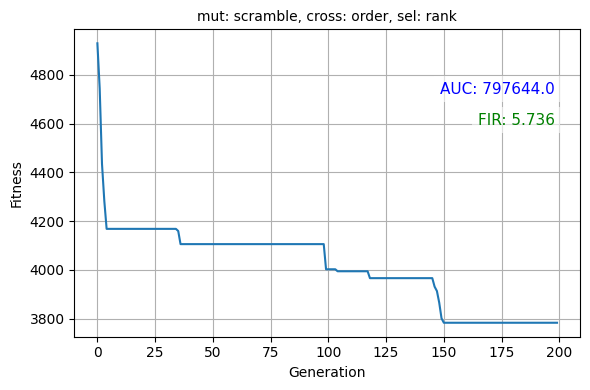

In [20]:

plot_single_combination_result('scramble', 'order', 'rank', results)



**Nhận xét (mut: scramble, cross: order, sel: rank):**

- **Giai đoạn đầu:** Fitness giảm từ khoảng 4900 xuống 4200, tốc độ cải thiện chậm hơn thuật toán trên 

- **Giai đoạn sau:** Có cải thiện nhẹ ở khoảng thế hệ 100–150, đạt mức thấp nhất khoảng 3780, cho thấy thuật toán có thể thoát khỏi hội tụ cục bộ nhờ mutation.
- **AUC:** **797644.0,**, **FIR:** **5.736** → AUC cao hơn biểu đồ 1 nhưng FIR thấp hơn → cho thấy vùng nghiệm tốt nhưng chất lượng nghiệm cuối không vượt trội.

**Đánh giá thuật toán:**
Tổ hợp này hoạt động với mức ổn định vừa phải, thể hiện qua tiến trình cải thiện fitness chậm hơn so với biểu đồ đầu tiên. Trong đó, rank selection giúp duy trì đa dạng quần thể tốt hơn nhưng lại có thể làm giảm áp lực chọn lọc, dẫn đến tốc độ cải tiến chậm. Order crossover cùng với scramble mutation góp phần tạo ra nhiều biến thể, giúp thuật toán tránh rơi vào hội tụ cục bộ, tuy nhiên điều này cũng có thể làm mất đi những cấu trúc tốt đã được học. Nhìn chung, tổ hợp này có khả năng tìm được vùng nghiệm tốt (thể hiện qua AUC cao), nhưng chất lượng nghiệm cuối cùng chưa thực sự nổi bật do FIR thấp.


# TRƯỜNG HỢP 3: FIR lớn, AUC nhỏ
- mutation: swap
- crossover: order
- selection: rank

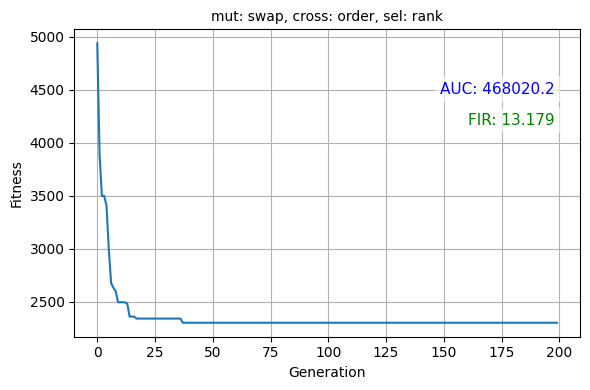

In [21]:
plot_single_combination_result('swap', 'order', 'rank', results)


**Nhận xét (mut: swap, cross: order, sel: rank):**

- **Giai đoạn đầu (0–40 thế hệ):**  fitness giảm nhanh từ khoảng 4900 xuống 2300, cho thấy thuật toán đã tìm được nghiệm tốt trong giai đoạn đầu. Sau đó, đường fitness gần như ổn định quanh mức 2300, không có cải thiện rõ rệt từ thế hệ 50 trở đi → biểu hiện của hiện tượng hội tụ sớm.

- **AUC: 468020.2, FIR: 13.179** → FIR cao hơn biểu đồ thứ hai và AUC thấp hơn → giải pháp đạt được có chất lượng tốt hơn, dù vùng nghiệm chưa rộng.

**Đánh giá thuật toán:**

Tổ hợp này hoạt động hiệu quả trong giai đoạn đầu, nhờ vào swap mutation giúp duy trì đa dạng vừa đủ. Order crossover hỗ trợ tái tổ hợp các cá thể một cách linh hoạt, trong khi rank selection đảm bảo sự cân bằng giữa khai thác và khám phá, giúp duy trì sự đa dạng quần thể. Tuy nhiên, việc hội tụ sớm cho thấy áp lực chọn lọc có thể chưa đủ để thúc đẩy cải tiến sâu hơn sau thế hệ thứ 50.

# TRƯỜNG HỢP 4: hội tụ chậm
- mutation: swap
- crossover: uniform
- selection: roulette_wheel

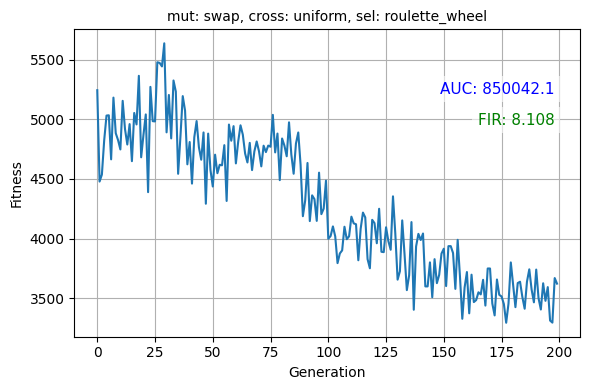

In [23]:
plot_single_combination_result('swap', 'uniform', 'roulette_wheel', results)

**Nhận xét (mut: swap, cross: uniform, sel: roulette_wheel):**

- Fitness có xu hướng giảm chậm và dao động mạnh trong suốt 200 thế hệ, bắt đầu từ mức khoảng 5000 và kết thúc ở khoảng 3400. Không có giai đoạn hội tụ rõ rệt, cho thấy quá trình tiến hóa không ổn định và hiệu quả cải tiến chưa cao.

- **AUC: 850042.1, FIR: 8.108** → AUC cao nhất trong các biểu đồ đã xét, cho thấy giải thuật khám phá được nhiều vùng nghiệm tốt; tuy nhiên, FIR trung bình, phản ánh chất lượng nghiệm cuối chỉ ở mức khá.

**Đánh giá thuật toán:**

Tổ hợp này có khả năng khám phá tốt nhờ uniform crossover kết hợp với swap mutation, tạo ra nhiều biến thể trong quần thể. Tuy nhiên, roulette wheel selection có thể gây thiếu áp lực chọn lọc, dẫn đến hiện tượng dao động và cải thiện không ổn định. Dù hiệu quả khai thác chưa cao (fitness giảm chậm), nhưng vùng nghiệm thu được lại rất rộng (AUC lớn), phù hợp cho các bài toán cần tìm kiếm đa dạng giải pháp hơn là tối ưu tuyệt đối.


